In [1]:
from pprint import pprint
from pandas_datareader.famafrench import get_available_datasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.api import OLS, add_constant
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader.data as web
from pathlib import Path
from linearmodels.asset_pricing import TradedFactorModel, LinearFactorModel, LinearFactorModelGMM

In [2]:
plt.style.use('fivethirtyeight')

In [33]:
ff_factor = 'F-F_Research_Data_5_Factors_2x3'
ff_factor_data = web.DataReader(ff_factor, 'famafrench', start='2010', end='2017-12')[0]
ff_factor_data.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 96 entries, 2010-01 to 2017-12
Freq: M
Data columns (total 6 columns):
Mkt-RF    96 non-null float64
SMB       96 non-null float64
HML       96 non-null float64
RMW       96 non-null float64
CMA       96 non-null float64
RF        96 non-null float64
dtypes: float64(6)
memory usage: 5.2 KB


In [34]:
ff_factor_data.describe()

,Mkt-RF,SMB,HML,RMW,CMA,RF
count,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000
mean,1.158437,0.057708,-0.065208,0.128542,0.049271,0.012604
std,3.579997,2.295902,2.194338,1.545694,1.409355,0.022583
min,-7.890000,-4.570000,-4.500000,-3.710000,-3.320000,0.000000
25%,-0.917500,-1.597500,-1.505000,-1.085000,-0.992500,0.000000
50%,1.235000,0.185000,-0.275000,0.240000,-0.005000,0.000000
75%,3.190000,1.505000,1.140000,1.135000,0.917500,0.010000
max,11.350000,6.810000,8.270000,3.610000,3.670000,0.090000


In [36]:
ff_portfolio = '17_Industry_Portfolios'
ff_portfolio_data = web.DataReader(ff_portfolio, 'famafrench', start='2010', end='2017-12')[0]
ff_portfolio_data = ff_portfolio_data.sub(ff_factor_data.RF, axis=0)
ff_factor_data = ff_factor_data.drop('RF', axis=1)
ff_portfolio_data.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 96 entries, 2010-01 to 2017-12
Freq: M
Data columns (total 17 columns):
Food     96 non-null float64
Mines    96 non-null float64
Oil      96 non-null float64
Clths    96 non-null float64
Durbl    96 non-null float64
Chems    96 non-null float64
Cnsum    96 non-null float64
Cnstr    96 non-null float64
Steel    96 non-null float64
FabPr    96 non-null float64
Machn    96 non-null float64
Cars     96 non-null float64
Trans    96 non-null float64
Utils    96 non-null float64
Rtail    96 non-null float64
Finan    96 non-null float64
Other    96 non-null float64
dtypes: float64(17)
memory usage: 13.5 KB


In [37]:
ff_portfolio_data.describe()

,Food,Mines,Oil,Clths,Durbl,Chems,Cnsum,Cnstr,Steel,FabPr,Machn,Cars,Trans,Utils,Rtail,Finan,Other
count,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000
mean,1.045625,0.202604,0.550833,1.396875,1.154792,1.302917,1.131146,1.731875,0.545000,1.357083,1.213125,1.275729,1.465625,0.891146,1.235000,1.244063,1.283854
std,2.796151,7.902260,5.571948,5.025430,5.137198,5.594069,3.177220,5.247261,7.348687,4.692277,4.815514,5.718919,4.151125,3.237148,3.509036,4.808025,3.711480
min,-5.170000,-24.380000,-11.990000,-10.000000,-13.210000,-17.390000,-7.300000,-13.960000,-20.490000,-11.960000,-9.090000,-11.650000,-8.560000,-6.990000,-9.180000,-11.020000,-7.920000
25%,-0.785000,-5.832500,-3.160000,-1.865000,-2.017500,-1.447500,-0.930000,-2.465000,-4.410000,-1.442500,-2.002500,-1.245000,-0.880000,-0.745000,-0.962500,-1.462500,-1.067500
50%,0.920000,-0.415000,1.050000,1.160000,1.205000,1.435000,1.495000,2.190000,0.660000,1.495000,1.515000,0.585000,1.505000,1.220000,0.880000,1.940000,1.585000
75%,3.187500,5.707500,3.912500,3.857500,4.315000,4.447500,3.272500,5.392500,4.220000,3.875000,4.575000,4.802500,4.227500,2.965000,3.355000,4.060000,3.522500
max,6.670000,21.920000,16.240000,17.200000,16.580000,18.370000,8.290000,15.560000,21.010000,17.660000,14.710000,20.860000,13.160000,7.900000,12.360000,13.430000,10.800000


In [4]:
with pd.HDFStore('../../data/assets.h5') as store:
    prices = store['/quandl/wiki/prices'].adj_close.unstack().loc['2010':'2017']
    equities = store['/us_equities/stocks'].drop_duplicates()

In [5]:
sectors = equities.filter(prices.columns, axis=0).sector.to_dict()
prices = prices.filter(sectors.keys()).dropna(how='all', axis=1)

In [6]:
returns = prices.resample('M').last().pct_change().mul(100).to_period('M')
returns = returns.dropna(how='all').dropna(axis=1)
returns.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 95 entries, 2010-02 to 2017-12
Freq: M
Columns: 1936 entries, A to ZUMZ
dtypes: float64(1936)
memory usage: 1.4 MB


#### Align data

In [7]:
ff_data = ff_data.loc[returns.index]

In [8]:
ff_data.describe()

,Mkt-RF,SMB,HML,RMW,CMA,RF
count,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000
mean,1.206000,0.055158,-0.069158,0.143789,0.045158,0.012737
std,3.568367,2.307945,2.205636,1.546619,1.416252,0.022665
min,-7.890000,-4.570000,-4.500000,-3.710000,-3.320000,0.000000
25%,-0.565000,-1.605000,-1.520000,-0.940000,-0.995000,0.000000
50%,1.290000,0.130000,-0.280000,0.300000,-0.010000,0.000000
75%,3.260000,1.550000,1.140000,1.150000,0.925000,0.010000
max,11.350000,6.810000,8.270000,3.610000,3.670000,0.090000


#### Compute excess Returns

In [9]:
excess_returns = returns.sub(ff_data.RF, axis=0)
excess_returns.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 95 entries, 2010-02 to 2017-12
Freq: M
Columns: 1936 entries, A to ZUMZ
dtypes: float64(1936)
memory usage: 1.4 MB


In [10]:
excess_returns = excess_returns.clip(lower=np.percentile(excess_returns, 1),
                                     upper=np.percentile(excess_returns, 99))

### Fama-Macbeth Regression

In [38]:
betas = []
for industry in ff_portfolio_data:
    step1 = OLS(endog=ff_portfolio_data[industry], 
                exog=add_constant(ff_factor_data)).fit()
    betas.append(step1.params.drop('const'))

In [39]:
betas = pd.DataFrame(betas, 
                     columns=ff_factor_data.columns, 
                     index=ff_portfolio_data.columns)
betas.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17 entries, Food  to Other
Data columns (total 5 columns):
Mkt-RF    17 non-null float64
SMB       17 non-null float64
HML       17 non-null float64
RMW       17 non-null float64
CMA       17 non-null float64
dtypes: float64(5)
memory usage: 1.4+ KB


#### Step 2: Risk Premia

In [41]:
lambdas = []
for period in ff_portfolio_data.index:
    step2 = OLS(endog=ff_portfolio_data.loc[period, betas.index], 
                exog=betas).fit()
    lambdas.append(step2.params)

In [42]:
lambdas = pd.DataFrame(lambdas, 
                       index=ff_portfolio_data.index,
                       columns=betas.columns.tolist())
lambdas.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 96 entries, 2010-01 to 2017-12
Freq: M
Data columns (total 5 columns):
Mkt-RF    96 non-null float64
SMB       96 non-null float64
HML       96 non-null float64
RMW       96 non-null float64
CMA       96 non-null float64
dtypes: float64(5)
memory usage: 7.0 KB


In [43]:
lambdas.mean()

Mkt-RF    1.201304
SMB       0.190127
HML      -1.306792
RMW      -0.570817
CMA      -0.522821
dtype: float64

In [46]:
t = lambdas.mean().div(lambdas.std())
t

Mkt-RF    0.333994
SMB       0.049492
HML      -0.288385
RMW      -0.179589
CMA      -0.156966
dtype: float64

#### Results

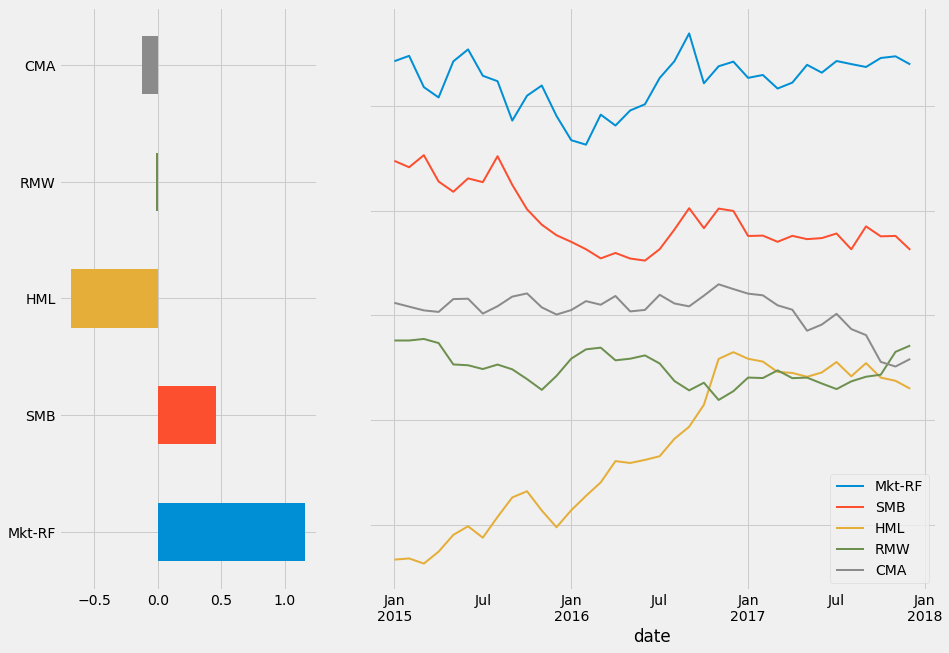

In [19]:
ax1 = plt.subplot2grid((1, 3), (0, 0))
ax2 = plt.subplot2grid((1, 3), (0, 1), colspan=2)
lambdas.mean().plot.barh(ax=ax1)
lambdas.rolling(60).mean().plot(lw=2, figsize=(14,10), sharey=True, ax=ax2);

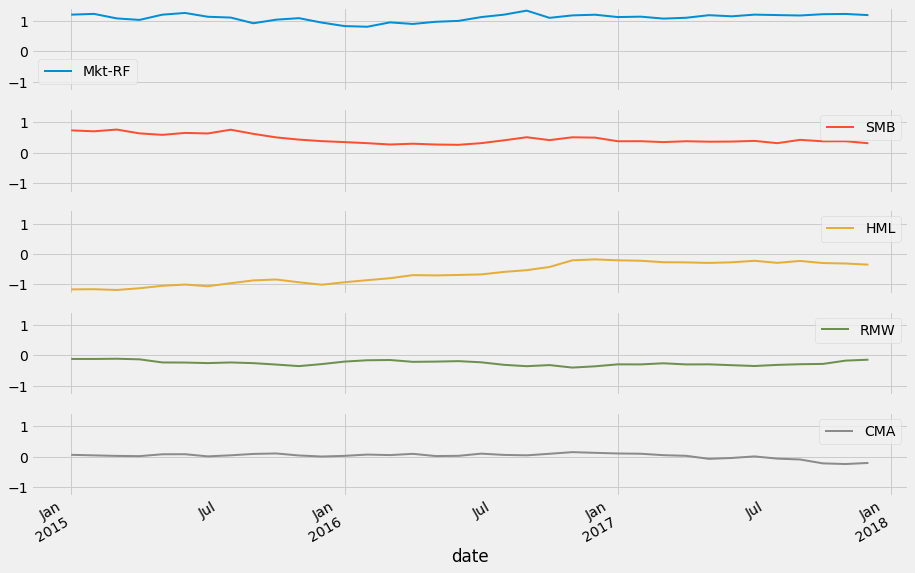

In [20]:
lambdas.rolling(60).mean().plot(lw=2, figsize=(14,10), subplots=True,sharey=True);

In [44]:
mod = LinearFactorModel(portfolios=ff_portfolio_data, 
                        factors=ff_factor_data)
res = mod.fit()
print(res)

                      LinearFactorModel Estimation Summary                      
No. Test Portfolios:                 17   R-squared:                      0.6925
No. Factors:                          5   J-statistic:                    16.973
No. Observations:                    96   P-value                         0.1506
Date:                  Tue, Sep 04 2018   Distribution:                 chi2(12)
Time:                          00:48:13                                         
Cov. Estimator:                  robust                                         
                                                                                
                            Risk Premia Estimates                             
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Mkt-RF         1.2013     0.4067     2.9535     0.0031      0.4041      1.9985
SMB            0.1901     0.8186    

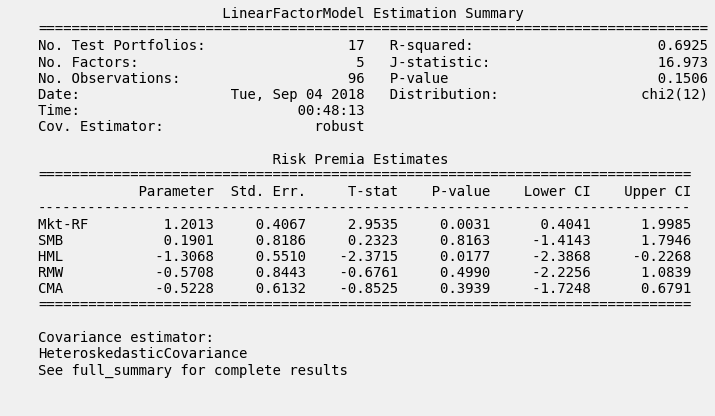

In [47]:
plt.rc('figure', figsize=(12, 7))
plt.text(0.01, 0.05, str(res), {'fontsize': 14}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.1)
plt.savefig('factor_model.png', bbox_inches='tight', dpi=300);

In [45]:
lambdas.mean()

Mkt-RF    1.201304
SMB       0.190127
HML      -1.306792
RMW      -0.570817
CMA      -0.522821
dtype: float64

In [68]:
mod = LinearFactorModel(portfolios=excess_returns, 
                        factors=factors,
                       risk_free=True)
res = mod.fit()
print(res)

                      LinearFactorModel Estimation Summary                      
No. Test Portfolios:                 90   R-squared:                      0.3186
No. Factors:                          5   J-statistic:                    6684.8
No. Observations:                    95   P-value                         0.0000
Date:                  Mon, Sep 03 2018   Distribution:                 chi2(84)
Time:                          09:26:07                                         
Cov. Estimator:                  robust                                         
                                                                                
                            Risk Premia Estimates                             
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
risk_free      1.2131     0.3623     3.3482     0.0008      0.5030      1.9232
Mkt-RF         0.2880     0.4521    